# LunarLander DQN Training

Interactive training notebook with configurable hyperparameters.

In [1]:
import gymnasium as gym
from src.envs.make_env import make_env
from src.agents.epsilon_greedy_agent import EpsilonGreedyAgent
from src.networks.q_network import QNetwork
from src.replay.replay_buffer import ReplayBuffer
from src.training.trainer import Trainer
import matplotlib.pyplot as plt
import numpy as np


## Hyperparameters Configuration

Modify these values to tune the training process:

In [2]:
# ============ TRAINING HYPERPARAMETERS ============
# Environment
num_episodes = 800
log_interval = 10  # Print stats every N episodes

# Training
train_every = 4  # Training step every N environment steps
batch_size = 64
learning_rate = 0.0005
gamma = 0.99  # Discount factor
interpolation_parameter = 1e-3  # Soft update rate for target network
replay_buffer_size = 50000

# Exploration
epsilon_starting_value = 1  # Initial exploration rate
epsilon_ending_value = 0.01   # Final exploration rate
epsilon_decay_value = 0.995   # Decay factor per episode

## Initialize Components

In [3]:
# Initialize Q-Network
q_network = QNetwork(input_size=8, output_size=4)

# Initialize epsilon from config
epsilon = epsilon_starting_value

# Initialize agent
agent = EpsilonGreedyAgent(action_space=4, q_network=q_network, epsilon=epsilon)

# Initialize replay buffer
replay_buffer = ReplayBuffer(max_size=replay_buffer_size)

# Initialize trainer with hyperparameters
trainer = Trainer(q_network, learning_rate=learning_rate, replay_buffer=replay_buffer, gamma=gamma)
trainer.interpolation_parameter = interpolation_parameter

# Create environment
env = make_env(render_mode="rgb_array")

c:\DataScience_Unitn\Lunar_Lander_Reinforcement_Learning\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## Training Loop with Visualization

In [4]:
# Training loop without visualization
episode_rewards = []
training_steps = 0

print("🚀 Starting training...\n")

for episode in range(num_episodes):
    obs, info = env.reset()
    total_reward = 0.0
    terminated = False
    truncated = False
    
    while not (terminated or truncated):
        # Ask agent for action
        action = agent.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Store transition in replay buffer
        done = terminated or truncated
        replay_buffer.add(obs, action, reward, next_obs, done)
        
        # Training step: sample batch and update network
        if training_steps % train_every == 0:
            loss = trainer.train_step(batch_size=batch_size)
        
        training_steps += 1
        total_reward += reward
        obs = next_obs
    
    episode_rewards.append(total_reward)
    
    # Decay epsilon after each episode
    epsilon = max(epsilon_ending_value, epsilon * epsilon_decay_value)
    agent.set_epsilon(epsilon)
    
    # Log average reward every N episodes
    if (episode + 1) % log_interval == 0:
        avg_reward = sum(episode_rewards[-log_interval:]) / log_interval
        print(f"Episodes {episode + 1 - log_interval + 1:4d}-{episode + 1:4d} | Avg Reward: {avg_reward:7.3f} | Epsilon: {epsilon:.4f}")

env.close()

print(f"\n✅ Training completed!")
print(f"Total episodes: {num_episodes}")
print(f"Replay buffer size: {len(replay_buffer)} transitions")
print(f"Total training steps: {training_steps}")
print(f"Final epsilon: {epsilon:.4f}")

🚀 Starting training...

Episodes    1-  10 | Avg Reward: -149.337 | Epsilon: 0.9511
Episodes   11-  20 | Avg Reward: -169.243 | Epsilon: 0.9046
Episodes   21-  30 | Avg Reward: -198.861 | Epsilon: 0.8604
Episodes   31-  40 | Avg Reward: -105.141 | Epsilon: 0.8183
Episodes   41-  50 | Avg Reward: -141.686 | Epsilon: 0.7783
Episodes   51-  60 | Avg Reward: -173.098 | Epsilon: 0.7403
Episodes   61-  70 | Avg Reward: -100.946 | Epsilon: 0.7041
Episodes   71-  80 | Avg Reward: -94.548 | Epsilon: 0.6696
Episodes   81-  90 | Avg Reward: -111.833 | Epsilon: 0.6369
Episodes   91- 100 | Avg Reward: -108.074 | Epsilon: 0.6058
Episodes  101- 110 | Avg Reward: -155.328 | Epsilon: 0.5762
Episodes  111- 120 | Avg Reward: -128.222 | Epsilon: 0.5480
Episodes  121- 130 | Avg Reward: -113.048 | Epsilon: 0.5212
Episodes  131- 140 | Avg Reward: -113.996 | Epsilon: 0.4957
Episodes  141- 150 | Avg Reward: -114.142 | Epsilon: 0.4715
Episodes  151- 160 | Avg Reward: -116.802 | Epsilon: 0.4484
Episodes  161- 17

## Plot Training Progress

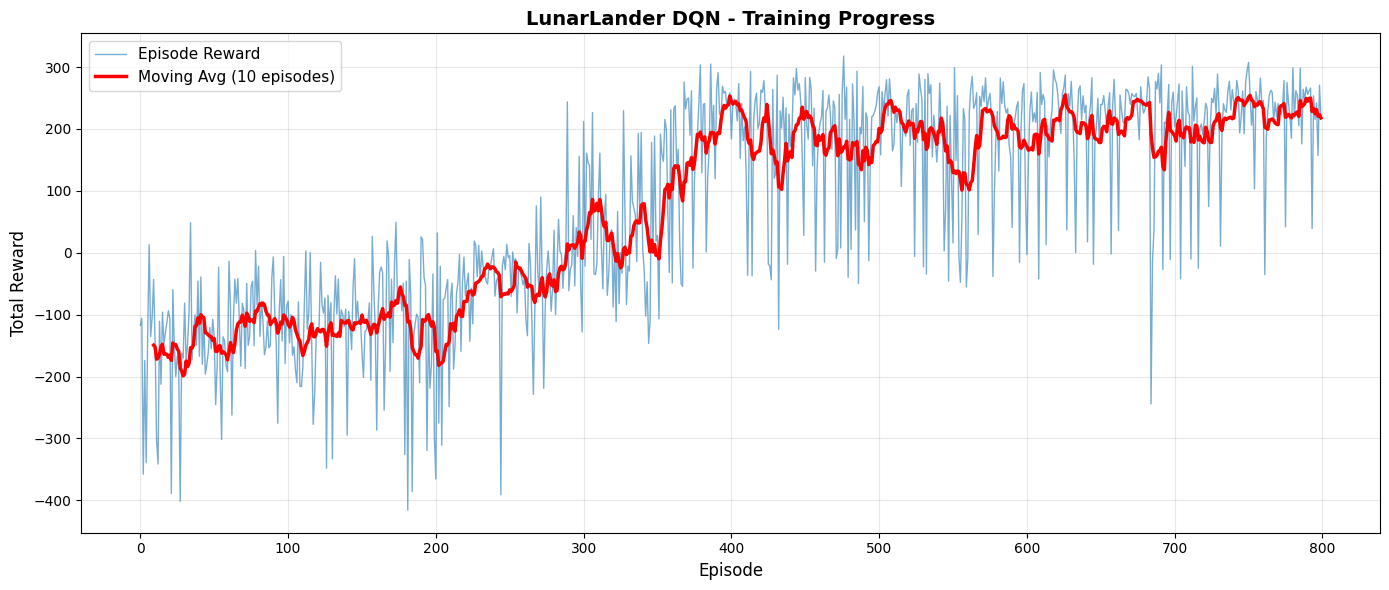


📊 Training Statistics:
  Average Reward: 73.339
  Max Reward: 317.726
  Min Reward: -415.618
  Std Dev: 170.967


In [5]:
# Plot episode rewards over time
plt.figure(figsize=(14, 6))
plt.plot(episode_rewards, alpha=0.6, label='Episode Reward', linewidth=1)

# Plot moving average
window = log_interval
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(episode_rewards)), moving_avg, linewidth=2.5, 
         label=f'Moving Avg ({window} episodes)', color='red')

plt.xlabel('Episode', fontsize=12)
plt.ylabel('Total Reward', fontsize=12)
plt.title('LunarLander DQN - Training Progress', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Training Statistics:")
print(f"  Average Reward: {np.mean(episode_rewards):.3f}")
print(f"  Max Reward: {np.max(episode_rewards):.3f}")
print(f"  Min Reward: {np.min(episode_rewards):.3f}")
print(f"  Std Dev: {np.std(episode_rewards):.3f}")

## Watch Trained Agent in Action

In [15]:
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
import glob

env = gym.make("LunarLander-v3", render_mode="rgb_array")

env = RecordVideo(
    env,
    video_folder="videos",
    episode_trigger=lambda episode_id: True,  # registra ogni episodio
    name_prefix="trained_agent"
)

obs, info = env.reset()
final_reward = 0.0
terminated = False
truncated = False

agent.set_epsilon(0.0)  # exploit only

while not (terminated or truncated):
    action = agent.act(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    final_reward += reward

env.close()

print(f"Final reward: {final_reward:.3f}")

video_path = glob.glob("videos/*.mp4")[0]
HTML(f"""
<video width="600" controls autoplay loop>
  <source src="{video_path}" type="video/mp4">
</video>
""")



Final reward: 262.620


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


True
12.1
